# Final statement - Dota 2 match winner prediction

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold

import itertools

### Подключение вспомогательных функций

In [11]:
%%capture 
%run nihil_ml_utils.ipynb

## Подготовка данных

In [3]:
# Загрузка данных
features = pd.read_csv(to_path('final_statement\\features.csv'),
                       index_col='match_id')
# Удаляем признаки, связанные с итогами матча
res_features = ['duration', 'radiant_win', 'tower_status_radiant',
                'tower_status_dire', 'barracks_status_radiant',
                'barracks_status_dire']
feat_wo_res = features.drop(columns=res_features)

### Обработка пропусков

In [4]:
# столбцы с пропусками
col_with_skips = feat_wo_res.isnull().sum(); col_with_skips[col_with_skips > 0]

first_blood_time               19553
first_blood_team               19553
first_blood_player1            19553
first_blood_player2            43987
radiant_bottle_time            15691
radiant_courier_time             692
radiant_flying_courier_time    27479
radiant_first_ward_time         1836
dire_bottle_time               16143
dire_courier_time                676
dire_flying_courier_time       26098
dire_first_ward_time            1826
dtype: int64

In [5]:
col_with_skips = col_with_skips[col_with_skips > 0]
print(list(col_with_skips.index))

['first_blood_time', 'first_blood_team', 'first_blood_player1', 'first_blood_player2', 'radiant_bottle_time', 'radiant_courier_time', 'radiant_flying_courier_time', 'radiant_first_ward_time', 'dire_bottle_time', 'dire_courier_time', 'dire_flying_courier_time', 'dire_first_ward_time']


### Про признаки с пропусками и почему они их содержат
Короткое объяснение - все эти признаки описывают события, которые могли не
не произойти за первые 5 минут игры.
Все множество признаков с пропусками можно разбить на три группы и дать
объяснение для каждой группы:
1. признаки связанные с событием first blood - событие могло не произойти в
   заданный отрезок времени (первые 5 минут игры).
   - Видно, что признак first_blood_player2 отсутсвует куда больше чем
      остальные из этой категории. Если предположить, что это игрок который
      совершил убийство, то для случаев, когда игрока убил NPC, этот
      признак будет пустым. Если это второй игрок, который помогал первому
      кого-то убивать - в таком случае возможны ситуации, когда первый игрок
      проделал всю работу в одиночку.
2. признаки связанные с покупкой предмета - предмет могли не купить в заданный
   отрезок времени
3. признаки связанные с первой установкой ward_observer - событие могло не
   произойти в заданный отрезок времени

In [6]:
# обработка пропущенных значений
feat_wo_res.fillna(0.0, inplace=True)

In [7]:
# Целевая переменная это 'radiant_win'
y = features['radiant_win']

### Настройка параметров кросс-валидации

In [8]:
# Cross-validation setup
kf = KFold(n_splits=5, shuffle=True, random_state=241)

## Подход 1: градиентный бустинг "в лоб"

In [13]:
n_estim_range = [10, 20, 30, 50, 100, 250]
results_gb = cross_validate_est(GradientBoostingClassifier, feat_wo_res, y, cv=kf,
                                scoring='roc_auc',
                                est_params={'random_state': 241},
                                par_key='n_estimators',
                                par_values=n_estim_range,
                                timed=True)

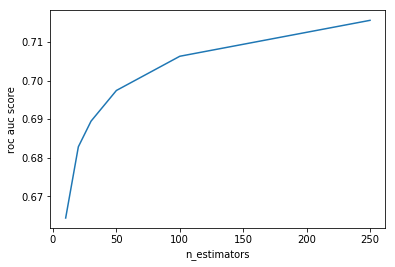

In [14]:
# Отрисовка результатов
plt.plot(results_gb.index, results_gb['mean'])
plt.xlabel('n_estimators')
plt.ylabel('roc auc score')
plt.show()

In [19]:
results_gb.loc[30, ['exec time (s)', 'mean']]

exec time (s)     94.0944
mean             0.689496
Name: 30, dtype: object

In [16]:
# Итого
best_n_est = results_gb['mean'].idxmax()
exec_time = results_gb.loc[best_n_est, 'exec time (s)']
print(f'Лучший результат при количестве деревьев: {best_n_est}, время выполнения: {exec_time:.2f} с')

Лучший результат при количестве деревьев: 250, время выполнения: 681.02 с


### Выводы по градиентному бустингу
Кросс-валидация градиентного бустинга с 30 деревьями заняла 94.09 с. Было достигнуто качество (метрика AUC-ROC) 0.69. Из графика видно что качество продолжает расти и после отметки в 30 деревьев, при этом кросс-валидация занимает весьма существенное время. 

Для того, чтобы как-то ускорить процесс обучения можно изменить параметр max_depth, отвечающий за максимальную глубину строящихся деревьев. Если пытаться улучшить процесс поиска наилучшего значения (то есть последовательный вызов метода для кросс валидации), то можно использовать warm_start - это приведет к переиспользованию модели с предыдущей итерации.

## Подход 2: логистическая регрессия

### Предобработка и настройка параметров

In [21]:
# Масштабирование признаков
scaler = StandardScaler()
X = scaler.fit_transform(feat_wo_res)

In [23]:
# Метод-помощник для определения лучшего коэффициента регуляризации и отрисовки графиков
def find_best_c(results):
    # plot logistic regression results
    plt.plot(np.log(results.index), results['mean'])
    plt.xlabel('log(C)')
    plt.ylabel('roc auc score')
    plt.show()
    # Best C
    best_C = results['mean'].idxmax()
    best_C_time = results.loc[best_C, 'exec time (s)']
    return best_C, results.loc[best_C, 'mean'], best_C_time

In [24]:
# Настройки кросс-валидации и списка значений коэффициента регуляризации (меньше С - сильнее регуляризация)
C_range = [1.0, 0.8, 0.6, 0.4, 0.2, 0.1, 0.01, 0.001, 0.0001]
cv_reg_def = {'cv': kf, 'scoring': 'roc_auc',
              'est_params': {'random_state': 241},
              'par_key': 'C', 'par_values': C_range,
              'timed': True}

### Кросс-валидация на всех признаках с масштабированием

In [28]:
results = cross_validate_est(LogisticRegression, X, y,
                             **cv_reg_def)

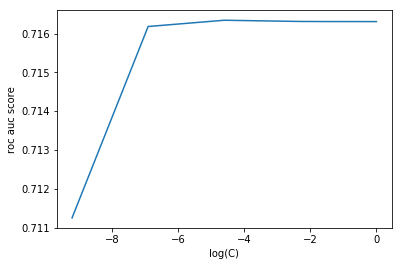

Best C: 0.01, AUC ROC: 0.72, Time: 68.74 c


In [30]:
best = find_best_c(results)
print(f'Best C: {best[0]}, AUC ROC: {best[1]:.2f}, Time: {best[2]:.2f} c')

### Кросс-валидация на признаках без категорийных, с масштабированием

In [31]:
# Удаляем категорийные признаки
cat_features = ['lobby_type'] + \
               [f'{prod[0]}{prod[1]}_hero'
                for prod in itertools.product(['r', 'd'], range(1, 6))]
feat_wo_cat = feat_wo_res.drop(columns=cat_features)

In [32]:
# масштабирование
X_wo_cat = scaler.fit_transform(feat_wo_cat)

In [33]:
res_wo_cat = cross_validate_est(LogisticRegression, X_wo_cat, y,
                                **cv_reg_def)

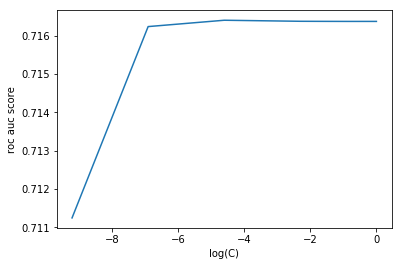

Best C: 0.01, AUC ROC: 0.72, Time: 65.00 c


In [34]:
best = find_best_c(res_wo_cat)
print(f'Best C: {best[0]}, AUC ROC: {best[1]:.2f}, Time: {best[2]:.2f} c')

### Кросс-валидация на всех признаках с подходом 'bag of words', с масштабированием

In [36]:
# Подсчет количества героев в игре
r_heroes = [f'r{i}_hero' for i in range(1, 6)]
d_heroes = [f'd{i}_hero' for i in range(1, 6)]
# Подход на основе словаря, так как если искать в данных матчей, то выходит, что некоторое количество героев не играли ни разу:
heroes_df = pd.read_csv(to_path('final_statement\\dictionaries\\heroes.csv'),
                        index_col='id')
n_heroes = len(heroes_df)
print(f'Количество героев: {n_heroes}')

Количество героев: 112


In [38]:
# Bag of words для категорийных признаков
X_pick = np.zeros((feat_wo_res.shape[0], n_heroes))
for i, match_id in enumerate(feat_wo_res.index):
    for p in range(5):
        X_pick[i, feat_wo_res.loc[match_id, 'r%d_hero' % (p+1)]-1] = 1
        X_pick[i, feat_wo_res.loc[match_id, 'd%d_hero' % (p+1)]-1] = -1

In [39]:
# склеиваем все вместе
X_full = np.hstack([X_wo_cat, X_pick])

In [40]:
res_full_lr = cross_validate_est(LogisticRegression, X_full, y, **cv_reg_def)

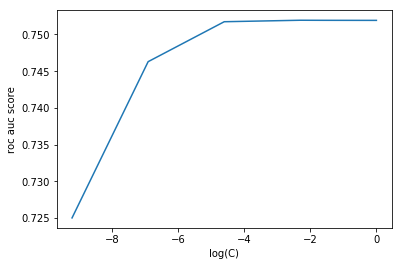

Best C: 0.1, AUC ROC: 0.75, Time: 111.12 c


In [41]:
best = find_best_c(res_full_lr)
print(f'Best C: {best[0]}, AUC ROC: {best[1]:.2f}, Time: {best[2]:.2f} c')

### Выводы по логистической регрессии
- Качество логистической регрессии над всеми признаками: Best C: 0.01, AUC ROC: 0.72, Time: 68.74 c. Качество чуть лучше чем у градиентного бустинга с 30 деревьями: 0.72 против 0.69. При увеличении количества деревьев в бустинге до 250 качество составляет 0.72. Также на качество бустинга могла оказать влияние замена пропусков на ноль. Время выполнения логистической регрессии значительно меньше чем у бустинга (30 деревьев) - 68.74 с против 94.09 с. Это связано в первую очередь с тем, что логистическая регрессиия более простой метод, требующий сравнительно меньших вычислений.
- Удаление категориальных признаков никак не повлияло на качество модели: Best C: 0.01, AUC ROC: 0.72, Time: 65.00 c. Но слегка улучшило время работы, что легко объясняется меньшим количеством признаков для обработки. Неизменность качества можно объяснить тем, что модель сочла категориальные признаки шумовыми и не настроилась на них.
- Всего в игре 112 героев, при этом в данном наборе партий сыграло 108 различных героев.
- Добавление "мешка слов" повысило качество до 0.75 и изменило оптимальный коэффициент регуляризации (был 0.01, стал 0.1). Это можно объяснить тем, что теперь категориальные признаки учитываются должным образом, а не являются шумом. Само влияние конкретной комбинации героев на исход матча является примером синергии, подход с мешком слов позволил эти синергию в некотором отношении учесть.
- На тестовой выборке max: 1, min: 0.01 (точность 2 занка после запятой)

## Прогнозирование для тестовой выборки

In [48]:
def create_bag(X, n):
    X_bag = np.zeros((X.shape[0], n))
    for i, match_id in enumerate(X.index):
        for p in range(5):
            X_bag[i, X.loc[match_id, 'r%d_hero' % (p + 1)] - 1] = 1
            X_bag[i, X.loc[match_id, 'd%d_hero' % (p + 1)] - 1] = -1
    return X_bag

In [42]:
def pre_process(df, feat_to_drop, n):
    df.fillna(0.0, inplace=True)
    df_wo = df.drop(columns=feat_to_drop)
    X = StandardScaler().fit_transform(df_wo)
    X_bagged = create_bag(df, n)
    return np.hstack([X, X_bagged])

In [43]:
clf = LogisticRegression(C=0.1)

In [44]:
clf.fit(X_full, y)

LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [49]:
# тестовая выборка
features_test = pd.read_csv(to_path('final_statement\\features_test.csv'),
                            index_col='match_id')
X_kaggle = pre_process(features_test, cat_features, n_heroes)

In [50]:
# прогнозирование
y_test = clf.predict_proba(X_kaggle)[:, 1]

In [53]:
# максимальные и минимальные значение на прогнозе
print(f'Test max: {y_test.max():.2f}, min: {y_test.min():.2f}')

Test max: 1.00, min: 0.01


In [52]:
# save results to file
y_test_df = pd.DataFrame({'radiant_win': y_test}, index=features_test.index)
y_test_df.index.name = 'match_id'
y_test_df.to_csv(f'./kaggle_pred_1.csv')